In [1]:
import numpy as np
import matplotlib.pyplot as plt
#import seaborn as sns

from tqdm.notebook import tqdm

In [2]:
from data_generator import *
from utilities import *
from mutation_detection import *
from tree_inference import *

### Data generator

In [ ]:
dg = DataGenerator(50, 400, coverage_sampler=coverage_sampler())
dg.random_tree()
dg.random_mutations(mut_prop = 0.5, genotype_freq = [1., 0., 0.])

In [ ]:
ref_raw, alt_raw = dg.generate_reads()

### Tree inference with generated data

In [ ]:
ref, alt, gt1, gt2 = filter_mutations(ref_raw, alt_raw, method = 'threshold', t = 0.5)

In [ ]:
likelihoods1, likelihoods2 = likelihood_matrices(ref, alt, gt1, gt2)

#### True tree

In [ ]:
optz = TreeOptimizer()
optz.fit(likelihoods1, likelihoods2, reversible = True)
optz.ct = dg.tree.copy()
optz.update_ct()

In [ ]:
optz.ct_joint / likelihoods1.size

In [ ]:
print('Distance matrix MSE to real tree:', path_len_dist(optz.ct, dg.tree))

In [ ]:
optz.mt.fit_structure(optz.ct)
optz.mt_L[:,optz.mt.root.ID] = np.sum(optz.likelihoods1, axis = 1)
optz.update_mt()

In [ ]:
optz.mt_joint / likelihoods1.size

#### All mutations reversible

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
optz = TreeOptimizer()
optz.fit(likelihoods2, likelihoods1, reversible = True)
print('Distance matrix MSE to real tree:', path_len_dist(optz.ct, dg.tree))

In [ ]:
optz.optimize(spaces = ['m', 'c'])

In [ ]:
mean_likelihoods = np.array(optz.likelihood_history) / likelihoods1.size
plt.plot(mean_likelihoods)

In [ ]:
print('MSE of distance matrix:', path_len_dist(optz.ct, dg.tree))
print('Cell tree mean loglikelihood:', optz.ct_joint / likelihoods1.size)
print('Mutation tree mean loglikelihood:', optz.mt_joint / likelihoods1.size)

#### No mutation reversible

In [ ]:
optz = TreeOptimizer()
optz.fit(likelihoods1, likelihoods2, reversible = False)
print('Distance matrix MSE to real tree:', path_len_dist(optz.ct, dg.tree))

In [ ]:
optz.optimize()

In [ ]:
mean_likelihoods = np.array(optz.likelihood_history) / likelihoods1.size
plt.plot(mean_likelihoods)

In [ ]:
print('MSE of distance matrix:', path_len_dist(optz.ct, dg.tree))
print('Cell tree mean loglikelihood:', optz.ct_joint / likelihoods1.size)
print('Mutation tree mean loglikelihood:', optz.mt_joint / likelihoods1.size)

### Apply to real data

In [ ]:
ref_raw, alt_raw = read_data('./Data/glioblastoma_BT_S2/ref.csv', './Data/glioblastoma_BT_S2/alt.csv')
print(ref_raw.shape)

In [ ]:
posteriors = mut_type_posteriors(ref_raw, alt_raw)
np.save('./test_results/real_data/posteriors.npy', posteriors)
#del posteriors

In [ ]:
n_select = 1000
posteriors = np.load('./test_results/real_data/posteriors.npy')
order = np.argsort(np.sum(posteriors[:,3:], axis = 1))
selected = order[-1000:]
ref, alt = ref_raw[:,selected], alt_raw[:,selected]
mut_type = np.argmax(posteriors[selected, 3:], axis = 1) 
gt1 = np.choose(mut_type, choices = ['R', 'H', 'H', 'A'])
gt2 = np.choose(mut_type, choices = ['H', 'A', 'R', 'H'])
#del posteriors, order, selected, mut_type
print(ref.shape)

In [ ]:
likelihoods1, likelihoods2 = likelihood_matrices(ref, alt, gt1, gt2)
np.save('./test_results/real_data/likelihoods1.npy', likelihoods1)
np.save('./test_results/real_data/likelihoods2.npy', likelihoods2)

In [3]:
likelihoods1 = np.load('./test_results/real_data/likelihoods1.npy')
likelihoods2 = np.load('./test_results/real_data/likelihoods2.npy')

In [4]:
optz = TreeOptimizer()
optz.fit(likelihoods1, likelihoods2)

In [5]:
optz.optimize()

[Cell Tree Space] timeout after 116800 steps and 4244 move(s).
[Mutation Tree Space] timeout after 200000 steps and 572 move(s).
[Cell Tree Space] timeout after 116800 steps and 167 move(s).
[Mutation Tree Space] timeout after 200000 steps and 123 move(s).
[Cell Tree Space] convergence after 18542 steps and 12 move(s).
[Mutation Tree Space] convergence after 28919 steps and 11 move(s).
[Cell Tree Space] convergence after 88907 steps and 41 move(s).
[Mutation Tree Space] convergence after 28940 steps and 6 move(s).
[Cell Tree Space] convergence after 15573 steps and 7 move(s).
[Mutation Tree Space] convergence after 38599 steps and 12 move(s).
[Cell Tree Space] convergence after 11725 steps and 3 move(s).
[Mutation Tree Space] convergence after 12414 steps and 1 move(s).
[Cell Tree Space] convergence after 13995 steps and 3 move(s).
[Mutation Tree Space] convergence after 19911 steps and 2 move(s).
[Cell Tree Space] convergence after 5840 steps and 0 move(s).
[Mutation Tree Space] conve

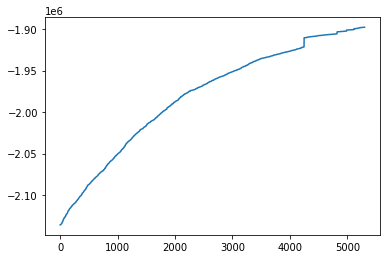

In [7]:
plt.plot(optz.likelihood_history)

In [8]:
np.save('./test_results/real_data/ct_parent_vec.npy', optz.ct.parent_vec)
np.save('./test_results/real_data/ct_attachments.npy', optz.ct.attachments)
np.save('./test_results/real_data/history.npy', optz.likelihood_history)

### Dendrogram

In [3]:
import seaborn as sns
from scipy.cluster.hierarchy import dendrogram

In [4]:
parent_vec = np.load('./Data/ct_parent_vec.npy')

In [5]:
ct = CellTree(len(parent_vec)//2 + 1)
ct.parent_vec = parent_vec

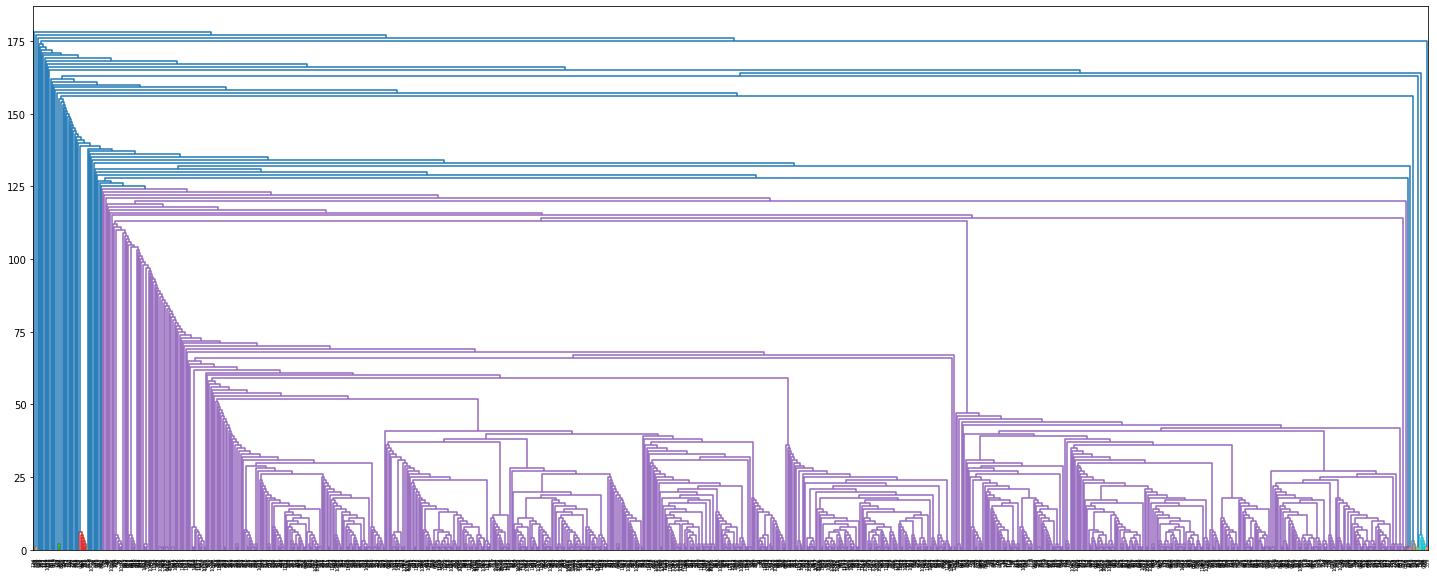

In [7]:
plt.figure(figsize=(25,10))
dendrogram(ct.linkage_matrix)
plt.show()